<a href="https://colab.research.google.com/github/Semere-Mesfin-Gebresilassie/Semere-Mesfin-Gebresilassie/blob/main/Mento_Carloo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import all necessary libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [10]:
# AASHTO Design Function

def aashto_1993_logW18(
    D, ZR, So, delta_PSI, Pt,
    Sc, Cd, J, Ec, k
):

    term1 = ZR * So
    term2 = 7.35 * np.log10(D + 1) - 0.06

    term3 = np.log10(delta_PSI / (4.5 - 1.5))
    term3 /= (1 + (1.624e7 / (D + 1)**8.46))

    numerator = Sc * Cd * (D**0.75 - 1.132)
    denominator = 215.63 * J * (
        D**0.75 - (18.42 / (Ec / k)**0.25)
    )

    term4 = (4.22 - 0.32 * Pt) * np.log10(numerator / denominator)

    return term1 + term2 + term3 + term4

In [11]:
# Thickness Solver Equation

def solve_thickness_aashto(
    W18, ZR, So, delta_PSI, Pt,
    Sc, Cd, J, Ec, k
):
    target_logW18 = np.log10(W18)

    D_low, D_high = 4.0, 20.0  # inches

    for _ in range(60):
        D_mid = (D_low + D_high) / 2

        logW18_mid = aashto_1993_logW18(
            D_mid, ZR, So, delta_PSI, Pt,
            Sc, Cd, J, Ec, k
        )

        if logW18_mid < target_logW18:
            D_low = D_mid
        else:
            D_high = D_mid

    return D_mid


In [12]:
# Mento Carloo Input Distributions

def sample_inputs():
    reliability = np.random.uniform(0.50, 0.99)  # 80%–99%
    ZR = norm.ppf(1 - reliability)               # AASHTO conversion

    return {
        "Reliability": reliability * 100,         # percent
        "ZR": ZR,
        "W18": np.random.uniform(0.5e6, 100e6),
        "So": np.random.uniform(0.20, 0.6),
        "delta_PSI": np.random.uniform(1.7, 2.5),
        "Pt": np.random.uniform(2.0, 3.0),
        "Sc": np.random.uniform(550, 800),
        "Cd": np.random.uniform(0.6, 1.3),
        "J": np.random.uniform(2.2, 4.5),
        "Ec": np.random.uniform(3.0e6, 6.0e6),
        "k": np.random.uniform(100, 500)
    }

In [13]:
# Monte Carlo Simulation

def monte_carlo_thickness(n_sim=10000):

    results = []

    for _ in range(n_sim):
        p = sample_inputs()

        D = solve_thickness_aashto(
            p["W18"], p["ZR"], p["So"], p["delta_PSI"], p["Pt"],
            p["Sc"], p["Cd"], p["J"], p["Ec"], p["k"]
        )

        results.append([
            p["Reliability"], p["W18"], p["ZR"], p["So"], p["delta_PSI"],
            p["Pt"], p["Sc"], p["Cd"], p["J"], p["Ec"], p["k"],
            D
        ])

    columns = [
        "Reliability_%", "W18", "ZR", "So", "Delta_PSI",
        "Pt", "Sc", "Cd", "J", "Ec", "k",
        "Thickness_in"
    ]

    return pd.DataFrame(results, columns=columns)

In [14]:
# Run Monte Carlo Simulation Analysis

df= monte_carlo_thickness(10000)

In [15]:
# Sensitivity Analysis (Effect on thickness)

sensitivity = df.corr()["Thickness_in"].sort_values()
print(sensitivity)

Cd              -0.481274
ZR              -0.340793
Sc              -0.240999
k               -0.086202
Delta_PSI       -0.046401
Pt              -0.002093
Ec               0.023907
So               0.132390
Reliability_%    0.329116
J                0.451960
W18              0.519569
Thickness_in     1.000000
Name: Thickness_in, dtype: float64


Thickness_in     1.000000
W18              0.519569
Cd              -0.481274
J                0.451960
ZR              -0.340793
Reliability_%    0.329116
Sc              -0.240999
So               0.132390
k               -0.086202
Delta_PSI       -0.046401
Ec               0.023907
Pt              -0.002093
Name: Thickness_in, dtype: float64


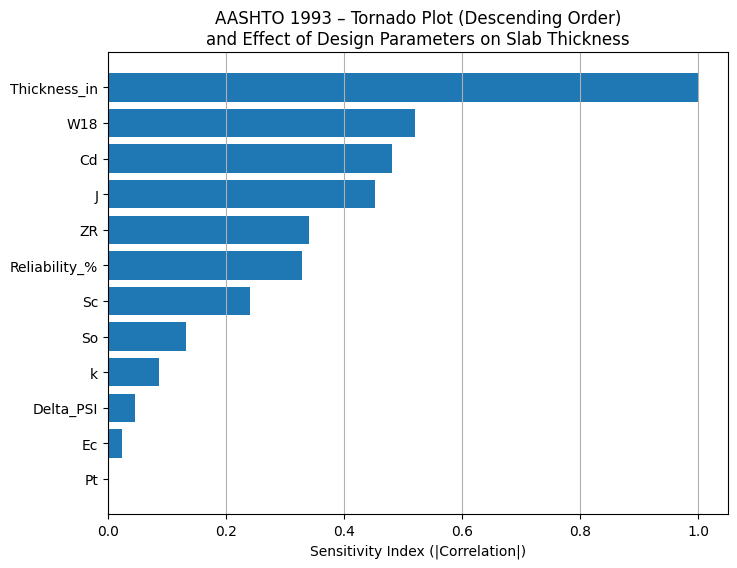

In [16]:
# Tornado Plot(Sensitivity rank in deecesnding order)

# Correlation-based sensitivity (effect on thickness)

sensitivity = df.corr()["Thickness_in"]

# Sort by absolute value in descending order
sensitivity_sorted = sensitivity.reindex(
    sensitivity.abs().sort_values(ascending=False).index
)

print(sensitivity_sorted)

plt.figure(figsize=(8, 6))

plt.barh(
    sensitivity_sorted.index,
    sensitivity_sorted.abs().values
)

plt.xlabel("Sensitivity Index (|Correlation|)")
plt.title(
    "AASHTO 1993 – Tornado Plot (Descending Order)\n"
    "and Effect of Design Parameters on Slab Thickness"
)

plt.gca().invert_yaxis()  # largest impact on top
plt.grid(True, axis="x")
plt.show()